 Les Biblios

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


In [2]:
import pandas as pd
import numpy as np
from joblib import load
from preprocessor import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from joblib import load

In [3]:
pip install imblearn


[notice] A new release of pip is available: 26.0 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# 1. Modèle Conditional VAE

In [4]:
class CVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, n_classes=2):
        super().__init__()
        
        # Encodeur
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + n_classes, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.mu = nn.Linear(32, latent_dim)
        self.logvar = nn.Linear(32, latent_dim)

        # Décodeur
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + n_classes, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, y_onehot):
        x_cond = torch.cat([x, y_onehot], dim=1)
        h = self.encoder(x_cond)
        mu, logvar = self.mu(h), self.logvar(h)
        z = self.reparameterize(mu, logvar)
        z_cond = torch.cat([z, y_onehot], dim=1)
        return self.decoder(z_cond), mu, logvar


# 2. Fonction de perte

In [5]:
def cvae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.MSELoss()(recon_x, x)
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl


# 3. Entraînement du cVAE

In [6]:
def train_cvae(X, y, latent_dim=10, epochs=50, batch_size=128):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # 🔑 conversion explicite
    X_np = X.values if hasattr(X, "values") else X
    y_np = y.values if hasattr(y, "values") else y

    X_t = torch.tensor(X_np, dtype=torch.float32)
    y_t = torch.tensor(y_np, dtype=torch.long)

    y_oh = torch.nn.functional.one_hot(y_t, num_classes=2).float()

    dataset = TensorDataset(X_t, y_oh)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = CVAE(X_t.shape[1], latent_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            recon, mu, logvar = model(xb, yb)
            loss = cvae_loss(recon, xb, mu, logvar)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss:.4f}")

    return model


# 4. Génération d’échantillons synthétiques (classe minoritaire)

In [7]:
def generate_synthetic_samples(model, n_samples, target_class, latent_dim):
    device = next(model.parameters()).device

    z = torch.randn(n_samples, latent_dim).to(device)
    y = torch.full((n_samples,), target_class, dtype=torch.long).to(device)
    y_oh = torch.nn.functional.one_hot(y, num_classes=2).float()

    z_cond = torch.cat([z, y_oh], dim=1)
    synthetic_X = model.decoder(z_cond).detach().cpu().numpy()
    
    synthetic_y = np.full(n_samples, target_class)
    return synthetic_X, synthetic_y


# 5. Fonction principale : équilibrage de la base

In [8]:
def balance_dataset_with_cvae(X, y, latent_dim=10):
    # Comptage des classes
    unique, counts = np.unique(y, return_counts=True)
    class_counts = dict(zip(unique, counts))

    minority_class = min(class_counts, key=class_counts.get)
    majority_class = max(class_counts, key=class_counts.get)

    n_to_generate = class_counts[majority_class] - class_counts[minority_class]

    print(f"Classe minoritaire : {minority_class}")
    print(f"Échantillons à générer : {n_to_generate}")

    # Entraînement
    model = train_cvae(X, y, latent_dim=latent_dim)

    # Génération
    X_syn, y_syn = generate_synthetic_samples(
        model, n_to_generate, minority_class, latent_dim
    )

    # Dataset équilibré
    X_balanced = np.vstack([X, X_syn])
    y_balanced = np.hstack([y, y_syn])

    return X_balanced, y_balanced


In [9]:
import pandas as pd
from joblib import load
from preprocessor import *
from sklearn.model_selection import train_test_split

## Masquage des labels

In [10]:
# Chargement des donnees
data = pd.read_csv('/home/onyxia/PROJET_STATAPP/Data/Cleans/Data_for_active_learning.csv')
data.head(2)

,Unnamed: 0,Make,AccidentArea,Sex,MaritalStatus,Age,Fault,PolicyType,VehiclePrice,FraudFound_P,...,Days_Policy_Accident,PastNumberOfClaims,AgeOfVehicle,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,delay_weeks
0,0,Honda,Urban,Female,Single,21,Policy Holder,Sport - Liability,more than 69000,0,...,more than 30,none,3 years,No,No,External,none,1 year,3 to 4,1
1,1,Honda,Urban,Male,Single,34,Policy Holder,Sport - Collision,more than 69000,0,...,more than 30,none,6 years,Yes,No,External,none,no change,1 vehicle,61


In [11]:
# Chargement des donnees non labelisees et des labels
no_labels_data = data.drop(columns=['FraudFound_P'])
labels = data['FraudFound_P']
no_labels_data.head(3)

,Unnamed: 0,Make,AccidentArea,Sex,MaritalStatus,Age,Fault,PolicyType,VehiclePrice,Deductible,...,Days_Policy_Accident,PastNumberOfClaims,AgeOfVehicle,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,delay_weeks
0,0,Honda,Urban,Female,Single,21,Policy Holder,Sport - Liability,more than 69000,300,...,more than 30,none,3 years,No,No,External,none,1 year,3 to 4,1
1,1,Honda,Urban,Male,Single,34,Policy Holder,Sport - Collision,more than 69000,400,...,more than 30,none,6 years,Yes,No,External,none,no change,1 vehicle,61
2,2,Honda,Urban,Male,Married,47,Policy Holder,Sport - Collision,more than 69000,400,...,more than 30,1,7 years,No,No,External,none,no change,1 vehicle,2


In [12]:
# Chargement du pipeline
preprocessor = load("preprocessor.joblib")

In [13]:
all_cols = binary_cols + label_cols + freq_cols + ordinal_cols + scale_cols # definit dans preprocessor.py
no_labels_data_preprocessed = preprocessor.fit_transform(no_labels_data)
no_labels_data_preprocessed = pd.DataFrame(no_labels_data_preprocessed, columns=all_cols)
no_labels_data_preprocessed.head(2)

,AccidentArea,Sex,Fault,PoliceReportFiled,WitnessPresent,AgentType,Make,MaritalStatus,PolicyType,VehiclePrice,Days_Policy_Accident,PastNumberOfClaims,AgeOfVehicle,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,DriverRating,Deductible,Age,delay_weeks
0,1.0,0.0,1.0,0.0,0.0,0.0,6.0,2.0,0.000065,5.0,4.0,0.0,2.0,0.0,2.0,2.0,1.0,300.0,-1.516574,-1.856357
1,1.0,1.0,1.0,1.0,0.0,0.0,6.0,2.0,0.022570,5.0,4.0,0.0,5.0,0.0,0.0,0.0,4.0,400.0,-0.489689,0.602140


## Séparation des donnees en 3 parties test/seed/pool

In [14]:
X_preprocessed = no_labels_data_preprocessed
y = labels


In [15]:
# 20% pour le test
X_pool_full, X_test, y_pool_full, y_test = train_test_split(
    X_preprocessed, y, test_size=0.2, stratify=y, random_state=42
)

# 2% d'observations initiales pour le seed dans le x_pool
X_init, X_pool, y_init, y_pool = train_test_split(
    X_pool_full, y_pool_full, train_size=0.02, stratify=y_pool_full, random_state=42
)

In [16]:
print ("Nombre de lignes du pool final : ",len(X_pool) ,
 "; Nombre de lignes du seed : ", len(X_init))

Nombre de lignes du pool final :  12089 ; Nombre de lignes du seed :  246


## Initialisation du modèle et CVAE

## Entrainement preliminaire du modele

In [17]:
# Chargement du modele
#lightgbm_model = load('/home/onyxia/PROJET_STATAPP/Notebooks/lgbm_untrained.joblib')

In [18]:
# fit du modele
#lightgbm_model.fit(X_seed, y_seed)

## Implementation de l'active learning

In [19]:
from lightgbm import LGBMClassifier

model = LGBMClassifier(
    learning_rate=0.05,
    max_depth=10,
    n_estimators=300,
    random_state=42
)

In [20]:
pip install lightgbm


[notice] A new release of pip is available: 26.0 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [21]:
## Boucle de l'active learning

In [22]:
# Tracking des résultats
results = []
#________________________________ Boucle d'active learning________________________________#

while len(X_init) < 12089 and len(X_pool) > 0:

    # ---- SMOTE sur le init ----
    X_init_cvae, y_init_cvae = balance_dataset_with_cvae(X_init, y_init)

    # ---- Entraînement ----
    model.fit(X_init_cvae, y_init_cvae)

    # ---- Évaluation sur le test set ----
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[:, 1]

    results.append({
        "labels_used": len(X_init),
        "accuracy": accuracy_score(y_test, y_test_pred),
        "f1": f1_score(y_test, y_test_pred),
        "recall": recall_score(y_test, y_test_pred),
        "precision": precision_score(y_test, y_test_pred),
        "auc": roc_auc_score(y_test, y_test_proba)
    })

    # ---- Prédiction sur le pool ----
    y_pool_proba = model.predict_proba(X_pool)[:, 1]

    # ---- Calcul du seuil de Youden sur le init ----
    y_init_proba = model.predict_proba(X_init)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_init, y_init_proba)
    youden = tpr - fpr
    best_idx = np.argmax(youden)
    youden_threshold = thresholds[best_idx]

    # ---- Sélection des 50 observations les plus proches du seuil ----
    dist_to_threshold = np.abs(y_pool_proba - youden_threshold)
    n_select = min(50, len(X_pool))  # sécurité si pool < 50
    query_idx = np.argsort(dist_to_threshold)[:n_select]

    # ---- Ajout des points au init ----
    X_new = X_pool.iloc[query_idx]
    y_new = y_pool.iloc[query_idx]
    X_init = pd.concat([X_init, X_new])
    y_init = pd.concat([y_init, y_new])

    # ---- Suppression des points du pool ----
    X_pool = X_pool.drop(X_pool.index[query_idx])
    y_pool = y_pool.drop(y_pool.index[query_idx])

    print(
        f"Iteration: {len(results)} | "
        f"Nouveaux labels: {n_select} | "
        f"Total labels: {len(X_init)} | "
        f"Youden threshold: {youden_threshold:.3f}"
    )

# -----------------------
# Résultats finaux
# -----------------------
results_df = pd.DataFrame(results)
results_df


Classe minoritaire : 1
Échantillons à générer : 216
Epoch 10/50 - Loss: 569575.7812
Epoch 20/50 - Loss: 114794.8125
Epoch 30/50 - Loss: 87559.1484
Epoch 40/50 - Loss: 79080.4219
Epoch 50/50 - Loss: 74361.2383
[LightGBM] [Info] Number of positive: 231, number of negative: 231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1598
[LightGBM] [Info] Number of data points in the train set: 462, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

,labels_used,accuracy,f1,recall,precision,auc
0,246,0.927691,0.089796,0.059459,0.183333,0.623757
1,296,0.937743,0.030303,0.016216,0.230769,0.591982
2,346,0.937419,0.010256,0.005405,0.100000,0.596834
3,396,0.938716,0.010471,0.005405,0.166667,0.648630
4,446,0.936770,0.020101,0.010811,0.142857,0.667649
...,...,...,...,...,...,...
232,11846,0.941310,0.133971,0.075676,0.583333,0.812265
233,11896,0.940013,0.070352,0.037838,0.500000,0.812177
234,11946,0.940337,0.098039,0.054054,0.526316,0.815841
235,11996,0.940337,0.098039,0.054054,0.526316,0.812269


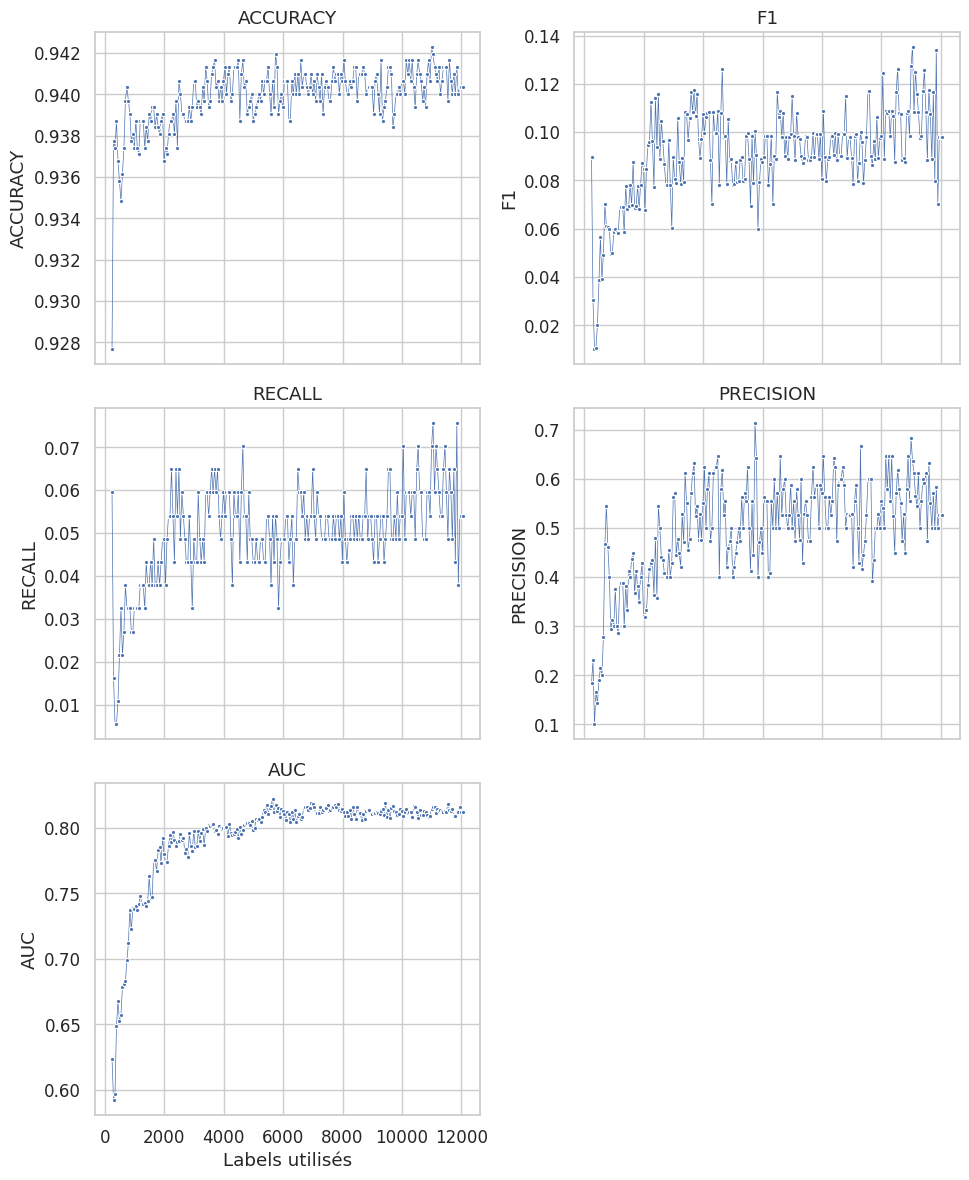

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import math

# Style seaborn
sns.set_theme(style="whitegrid", palette="deep", font_scale=1.1)

metrics = ["accuracy", "f1", "recall", "precision", "auc"]
n_metrics = len(metrics)

# Déterminer nombre de colonnes pour 2 lignes
n_rows = 3
n_cols = math.ceil(n_metrics / n_rows)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), sharex=True)

# Aplatir axes si nécessaire
axes = axes.flatten()

for i, m in enumerate(metrics):
    ax = axes[i]
    sns.lineplot(
        x=results_df["labels_used"],
        y=results_df[m],
        marker=".",
        linewidth=0.5,
        ax=ax
    )
    ax.set_title(m.upper())
    ax.set_xlabel("Labels utilisés")
    ax.set_ylabel(m.upper())

# Supprimer les axes vides si n_metrics < n_rows * n_cols
for j in range(n_metrics, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
